Centralized model using CNN for MRI dataset

In [1]:
# Cell A — Paths & config
import os
import tensorflow as tf
import matplotlib.pyplot as plt

SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# If you're on Windows-native Python, this is fine:
DATA_DIR = r"/home/amint/HEP/Brain Tumor MRI"

# If you're running inside WSL, use the Linux mount path instead:
# DATA_DIR = "/mnt/d/Ascl_Mimic_Data/Brain Tumor MRI"

train_dir = os.path.join(DATA_DIR, "Training")
test_dir  = os.path.join(DATA_DIR, "Testing")


2025-08-29 17:04:25.915867: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-29 17:04:26.196487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-29 17:04:27.894706: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Cell B — Create train/val from Training, test from Testing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.20,      # 20% of Training becomes validation
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.20,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False,              # keep order stable for evaluation
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.


I0000 00:00:1756479870.392435   86590 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-08-29 17:04:30.745598: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:41] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykernel_launcher.runfiles/cuda_nvdisasm
  ipykernel_launcher.runfiles/nvidia_nvshmem
  ipykern/cuda_nvcc
  ipykern/cuda_nvdisasm
  ipykern/nvidia_nvshmem
  
  /usr/local/cuda
  /opt/cuda
  /home/amint/HEP/.venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/amint/HEP/.venv/lib/python3.12/site-packages/tensorflow/

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# Cell C — Preprocess (rescale), cache, prefetch
def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y),
                num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(BATCH_SIZE * 8, seed=SEED)
    return ds.cache().prefetch(AUTOTUNE)

train_ds_p = prepare(train_ds, training=True)
val_ds_p   = prepare(val_ds)
test_ds_p  = prepare(test_ds)


2025-08-29 17:04:50.844513: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-29 17:04:50.938941: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train counts: {'glioma': np.int64(1077), 'meningioma': np.int64(1090), 'notumor': np.int64(1247), 'pituitary': np.int64(1156)}
Val counts:   {'glioma': np.int64(244), 'meningioma': np.int64(249), 'notumor': np.int64(348), 'pituitary': np.int64(301)}
Test counts:  {'glioma': np.int64(300), 'meningioma': np.int64(306), 'notumor': np.int64(405), 'pituitary': np.int64(300)}


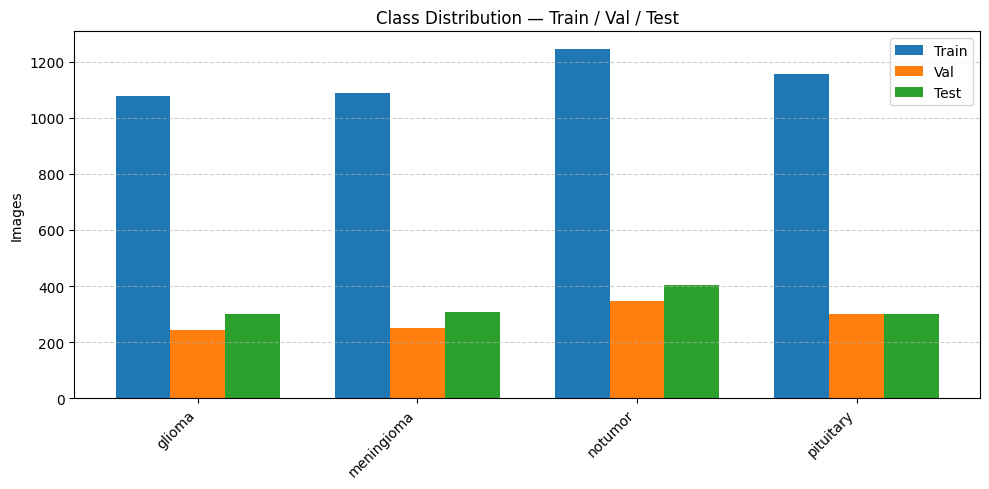

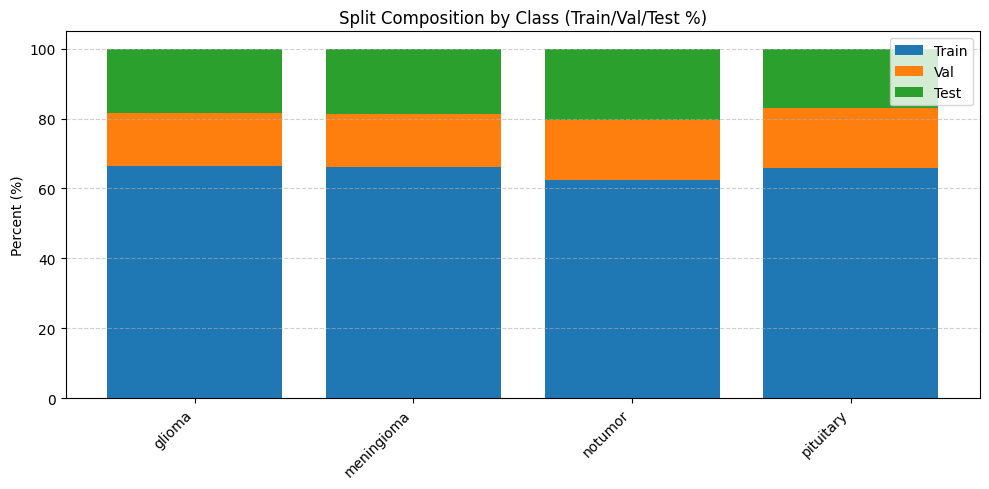

In [4]:
# Class distribution: counts and plots

import numpy as np
import matplotlib.pyplot as plt

def count_by_class(ds, num_classes):
    """Return counts per class (length = num_classes) from a batched tf.data dataset."""
    counts = np.zeros(num_classes, dtype=int)
    for _, y in ds:
        y_np = y.numpy()
        counts += np.bincount(y_np, minlength=num_classes)
    return counts

# Count images per class for each split
train_counts = count_by_class(train_ds, num_classes)
val_counts   = count_by_class(val_ds,   num_classes)
test_counts  = count_by_class(test_ds,  num_classes)

# Print a tidy summary
print("Train counts:", dict(zip(class_names, train_counts)))
print("Val counts:  ", dict(zip(class_names, val_counts)))
print("Test counts: ", dict(zip(class_names, test_counts)))

# ---- Plot 1: Grouped bar chart (absolute image counts) ----
x = np.arange(num_classes)
width = 0.25

plt.figure(figsize=(10, 5))
plt.bar(x - width, train_counts, width, label="Train")
plt.bar(x,         val_counts,   width, label="Val")
plt.bar(x + width, test_counts,  width, label="Test")
plt.xticks(x, class_names, rotation=45, ha="right")
plt.ylabel("Images")
plt.title("Class Distribution — Train / Val / Test")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ---- Plot 2: Stacked bars by split percentage within each class ----
# For each class, show what % of images come from Train/Val/Test
total_per_class = train_counts + val_counts + test_counts
# Avoid division by zero with where=...
train_pct = np.divide(train_counts, total_per_class, where=total_per_class>0) * 100
val_pct   = np.divide(val_counts,   total_per_class, where=total_per_class>0) * 100
test_pct  = np.divide(test_counts,  total_per_class, where=total_per_class>0) * 100

plt.figure(figsize=(10, 5))
plt.bar(class_names, train_pct, label="Train")
plt.bar(class_names, val_pct,   bottom=train_pct, label="Val")
plt.bar(class_names, test_pct,  bottom=train_pct+val_pct, label="Test")
plt.ylabel("Percent (%)")
plt.title("Split Composition by Class (Train/Val/Test %)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


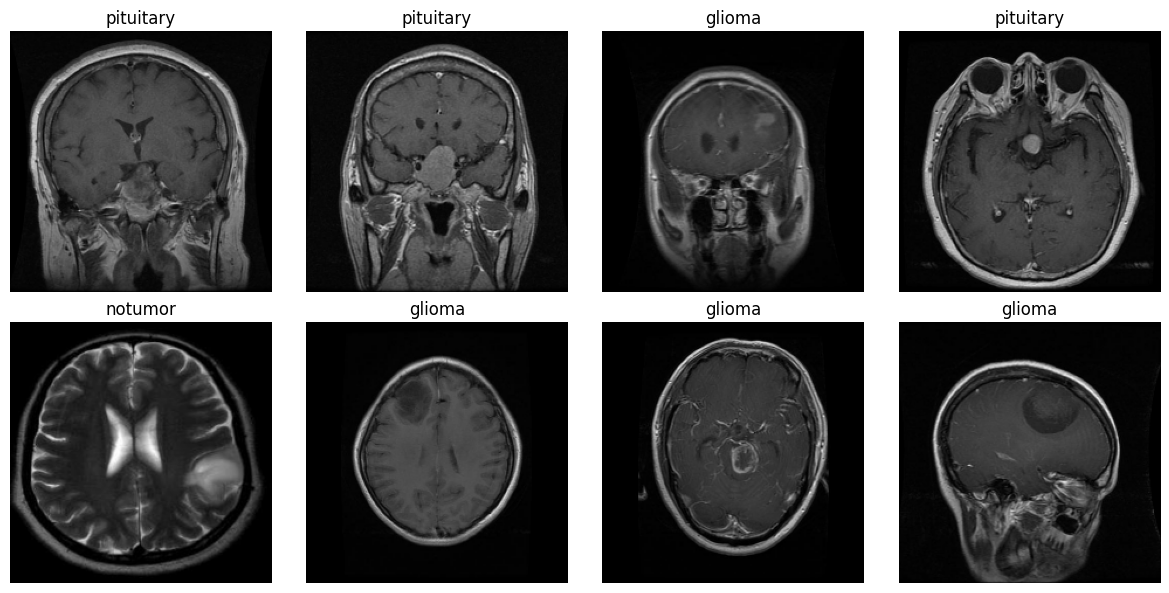

2025-08-29 17:04:53.246230: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Cell D — Show a grid of sample training images with labels
import math

def show_samples(ds, n=12):
    # grabs one batch and shows n images
    for images, labels in ds.take(1):
        n = min(n, images.shape[0])
        rows = math.ceil(n/4)
        plt.figure(figsize=(12, 3*rows))
        for i in range(n):
            ax = plt.subplot(rows, 4, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i])])
            plt.axis("off")
        plt.tight_layout()
        plt.show()

show_samples(train_ds, n=8)


In [7]:
# from tensorflow.keras.optimizers import SGD
# model.compile(
#     optimizer=SGD(learning_rate=0.01, momentum=0.9),
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"],
#     jit_compile=False,
# )

In [8]:
# Cell E — CNN model (uses Legacy Adam to avoid rare JIT issues)
from tensorflow.keras.optimizers import SGD

EPOCHS = 50  # change as you like

def create_model(num_classes: int):
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1),
    ])
    inputs = tf.keras.Input(shape=(224, 224, 3))  # uses IMG_SIZE=(224,224)
    x = aug(inputs)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=SGD(1e-3),                 # stable, avoids XLA pow crash
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        jit_compile=False,                          # keep XLA off just in case
    )
    return model

model = create_model(num_classes)
model.summary()


2025-08-29 17:05:18.146929: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-29 17:05:18.148449: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-29 17:05:18.149768: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-29 17:05:18.151079: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-29 17:05:18.152392: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-29

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,700 (84.86 MB)

 Trainable params: 22,245,700 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Cell F — Train the CNN
history = model.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/50


E0000 00:00:1756479923.999486   86590 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-29 17:05:26.525095: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-29 17:05:26.526773: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-29 17:05:26.528234: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-08-29 17:05:26.529681: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to com

143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.2867 - loss: 1.3405 - val_accuracy: 0.3056 - val_loss: 1.2712
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3611 - loss: 1.2665 - val_accuracy: 0.5149 - val_loss: 1.1692
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4781 - loss: 1.1892 - val_accuracy: 0.6252 - val_loss: 1.0648
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.5284 - loss: 1.1218 - val_accuracy: 0.6620 - val_loss: 0.9779
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.5648 - loss: 1.0574 - val_accuracy: 0.6751 - val_loss: 0.9086
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5812 - loss: 1.0159 - val_accuracy: 0.6883 - val_loss: 0.8571
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6066 - loss: 0.9834 - val_accuracy: 0.7075 - val_loss: 0.8203
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6249 - loss: 0.9527 - val_accuracy: 0.71

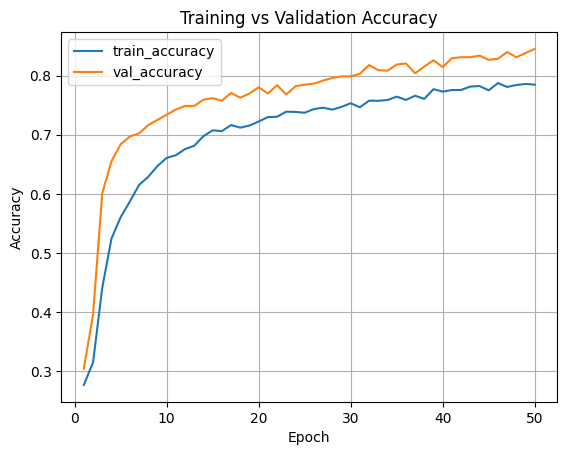

In [ ]:
# Cell G — Plot Training & Validation Accuracy
import matplotlib.pyplot as plt

acc     = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])

plt.figure()
plt.plot(range(1, len(acc)+1), acc,     label="train_accuracy")
plt.plot(range(1, len(val_acc)+1), val_acc, label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


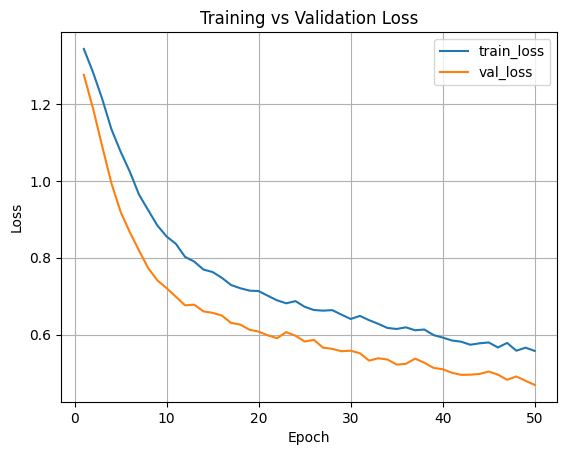

In [ ]:
# Cell H — Plot Training & Validation Loss
loss     = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

plt.figure()
plt.plot(range(1, len(loss)+1), loss,     label="train_loss")
plt.plot(range(1, len(val_loss)+1), val_loss, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Cell I — Test-set evaluation: Accuracy, Precision, Recall, F1
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

y_true, y_pred = [], []
for xb, yb in test_ds_p:
    probs = model.predict(xb, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(preds.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_acc = accuracy_score(y_true, y_pred)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

print(f"TEST — Accuracy: {test_acc:.4f}")
print(f"TEST — Precision (weighted): {prec_w:.4f}")
print(f"TEST — Recall (weighted):    {rec_w:.4f}")
print(f"TEST — F1-score (weighted):  {f1_w:.4f}")

print("\nPer-class report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


TEST — Accuracy: 0.7834
TEST — Precision (weighted): 0.7802
TEST — Recall (weighted):    0.7834
TEST — F1-score (weighted):  0.7792

Per-class report:

              precision    recall  f1-score   support

      glioma       0.79      0.64      0.71       300
  meningioma       0.61      0.60      0.61       306
     notumor       0.84      0.91      0.88       405
   pituitary       0.85      0.94      0.90       300

    accuracy                           0.78      1311
   macro avg       0.78      0.77      0.77      1311
weighted avg       0.78      0.78      0.78      1311



2025-08-29 16:00:22.614947: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


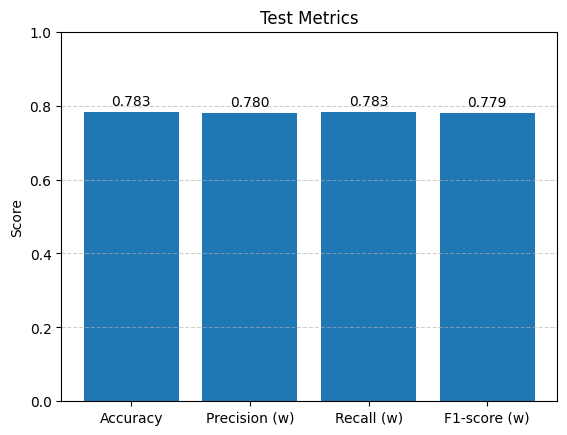

In [ ]:
# Bar chart of test metrics
import matplotlib.pyplot as plt

metrics_names = ["Accuracy", "Precision (w)", "Recall (w)", "F1-score (w)"]
metrics_vals  = [test_acc, prec_w, rec_w, f1_w]

plt.figure()
bars = plt.bar(metrics_names, metrics_vals)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Test Metrics")
for b, v in zip(bars, metrics_vals):
    plt.text(b.get_x() + b.get_width()/2.0, v + 0.01, f"{v:.3f}", ha="center", va="bottom")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


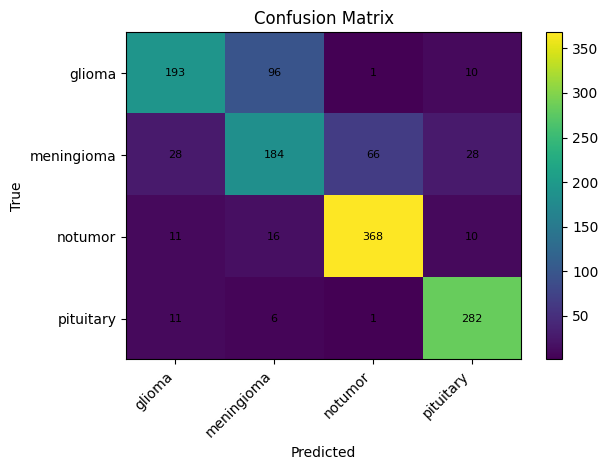

In [ ]:
# (Optional) Confusion matrix heatmap
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

fig, ax = plt.subplots()
im = ax.imshow(cm, aspect="auto")
plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.show()


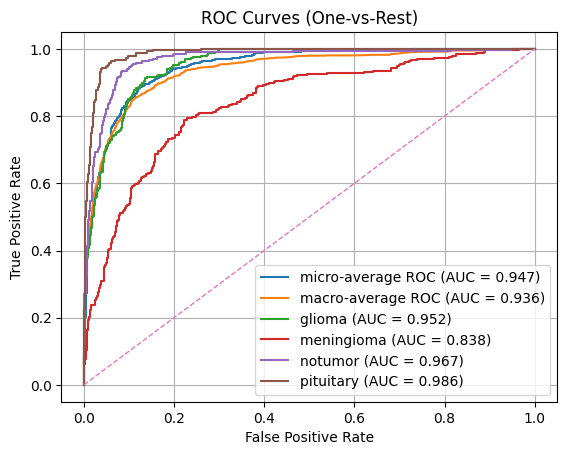

In [ ]:
# ROC & AUC (per-class, micro, macro) and plot

import numpy as np
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 1) Collect probabilities and labels for the whole test set
y_scores_list, y_true_list = [], []
for xb, yb in test_ds_p:
    probs = model.predict(xb, verbose=0)   # shape [batch, num_classes]
    y_scores_list.append(probs)
    y_true_list.append(yb.numpy())

y_score = np.concatenate(y_scores_list, axis=0)      # (N, C) predicted probabilities
y_true_int = np.concatenate(y_true_list, axis=0)     # (N,) integer labels
y_true = to_categorical(y_true_int, num_classes=num_classes)  # (N, C) one-hot

# 2) Compute per-class ROC and AUC (one-vs-rest)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3) Micro-average ROC/AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4) Macro-average ROC/AUC (average of interpolated per-class TPRs)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5) Plot ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], label=f"macro-average ROC (AUC = {roc_auc['macro']:.3f})")
for i, name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f"{name} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
